In [169]:
import azureml.core
# Packages to load Workspace and get registered Models
from azureml.core import Workspace, Model
# Package to load define Environment dependencies
from azureml.core.conda_dependencies import CondaDependencies 

# Packages for deployment
from azureml.core.model import InferenceConfig

import os, shutil

In [170]:
#*###########################
#* CONNECT TO THE WORKSPACE
#*
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.31.0 to work with ws_Machine_Learning


In [171]:
#*###########################
#* GET THE DESIRE MODEL FROM
#* THE WORKSPACE
#*
# Print all models in the workspace 
"""
for model in Model.list(ws):
     print(model.name, 'version:', model.version)
     for tag_name in model.tags:
         tag = model.tags[tag_name]
         print ('\t',tag_name, ':', tag)
     for prop_name in model.properties:
         prop = model.properties[prop_name]
         print ('\t',prop_name, ':', prop)
     print('\n')
"""

# Search and get the model name from the desired version
model_name = 'Conv2DNet_ID0056C02_CV'
model_id = 'Conv2DNet_ID0056C02_CV:1'

# Get all models in the workspace with the desired model name
for m in Model.list(ws, name=model_name):
    # Evaluate if the current model version is the desired one
    if m.id == model_id:
        model = m

# Get the model to deploy
# model = ws.models['Conv2DNet_ID0035C02_noCV:1']     # Returns the model with higher version
print('Loaded ', model.name, 'model version', model.version)


Loaded  Conv2DNet_ID0056C02_CV model version 1


In [172]:
#*#####################################
#* CREATE WEBSERVICE FOLDERS AND FILES 
#* TO HOST THE MODEL
#*

#* IMPORTANT: BEFORE RUNNING THIS CELL, MAKE SURE THAT 
#* THE SCORING SCRIPT IS USING THE SAME MODEL NAME AS 
#* THE ONE LOADED IN THE PREVIOUS CELL
folder_name = 'brain_classification_service'

# Delete previously created folders to update new files. Ignore errors in case there is no folder with that name
shutil.rmtree(folder_name, ignore_errors=True)

# Create a folder for the web service files
source_directory = './' + folder_name
os.makedirs(source_directory, exist_ok=True)
print(folder_name, 'folder created.')

# Copy the necessary Python files into the experiment folder
shutil.copy('.score_brain.py', os.path.join(source_directory, "score_brain.py"))
shutil.copy('./Libraries/preProcessing_chain.py', os.path.join(source_directory, "preProcessing_chain.py"))
shutil.copy('./Libraries/metrics.py', os.path.join(source_directory, "metrics.py"))
shutil.copy('./Libraries/nn_models.py', os.path.join(source_directory, "nn_models.py"))
shutil.copy('./Libraries/hsi_dataManager.py', os.path.join(source_directory, "hsi_dataManager.py"))


#*###########################
#* INDICATE CONTAINER HOST
#* TO INSTALL OUR REQUIRED
#* PYTHON DEPENDENCIES
#*

# Add the dependencies for our model (AzureML defaults is already included)
myenv = CondaDependencies.create(conda_packages=['scikit-learn','ipykernel','matplotlib','numpy', 'pillow', 'pip'],
                                                pip_packages=['azureml-sdk', 'azureml-defaults', 'pyarrow==3.0.0', 'torch', 'scipy', 'tqdm'],
                                                python_version='3.8.10')

# Save the environment config as a .yml file
env_file = os.path.join(source_directory, "brain_env.yml")

with open(env_file, "w") as f:
    f.write(myenv.serialize_to_string())

print("Saved dependency info in", env_file)

brain_classification_service folder created.
Saved dependency info in ./brain_classification_service\brain_env.yml


In [173]:
#*###########################
#* DEPLOY THE MODEL AS A 
#* WEBSERVICE
#*
from azureml.core.webservice import AksEndpoint
from azureml.core.compute import AksCompute
from timeit import default_timer as timer       # Import timeit to measure times in the script

service_name = 'brain-service'

# ACI only have 60 seconds timeout on the run(). Therefore we need to use AKS
# ACI does not have GPU cores, so we cannot predict with our CNN models using CUDA 
aks_name = 'aks-cluster'

# Select a created compute
compute = AksCompute(ws, aks_name)


# Create the deployment config and define the scoring traffic percentile for the first deployment
deployment_config = AksEndpoint.deploy_configuration(cpu_cores = 0.1, memory_gb = 0.5, gpu_cores = 0.1, scoring_timeout_ms=240000)

# Configure the scoring environment
inference_config = InferenceConfig(entry_script="score_brain.py",
                                    source_directory=source_directory,
                                    conda_file="brain_env.yml",
                                    runtime= "python"   )

start = timer()

service = Model.deploy(ws, service_name, [model], inference_config, deployment_config, compute)

service.wait_for_deployment(True)

end = timer()
# Measure time elapsed parsing arguments
time_deploying = (end - start)

print(service.state)
print('Deploying time: ', time_deploying)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-07-06 20:37:16+02:00 Creating Container Registry if not exists.
2021-07-06 20:37:16+02:00 Registering the environment.
2021-07-06 20:37:17+02:00 Use the existing image for brain-service.
2021-07-06 20:37:19+02:00 Creating resources in AKS.
2021-07-06 20:37:20+02:00 Submitting deployment to compute.
2021-07-06 20:37:20+02:00 Checking the status of deployment brain-service..
2021-07-06 20:37:30+02:00 Checking the status of inference endpoint brain-service.
Succeeded
AKSENDPOINT service creation operation finished, operation "Succeeded"
Healthy
Deploying time:  25.404108999995515


Done serializing data to JSON
Sending data to webservice. Please wait...
Received data from scoring script!
time_request_response =  29.40742489999684


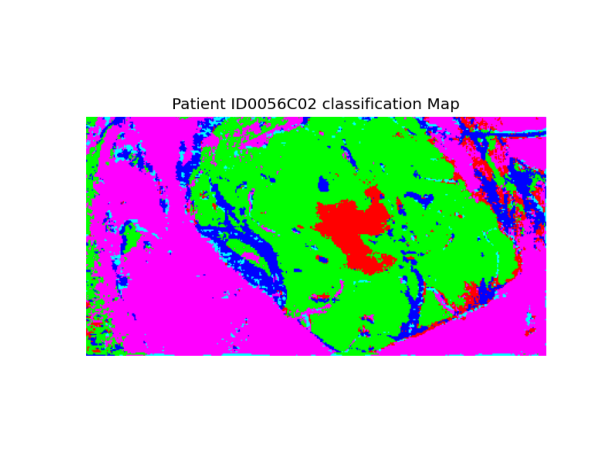


time_parsing_data =  1.0915825680003763
time_preProcessing_data =  0.5013104449990351
time_preparing_batches =  12.522294221000266
time_predict_cMap =  3.226377668999703
Total elapsed time =  17.34156490299938


In [174]:
# Packages to connect to the container and send requests 
import json
from json import JSONEncoder


# Packages to load data
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

# Import timeit to measure times in the script
from timeit import default_timer as timer

#*##########################
#* NumpyArrayEncoder class
#*
class NumpyArrayEncoder(JSONEncoder):
    """
    Class to serialize Numpy arrays to JSON objects.
    Other object instances are enconded by default.
    """
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

#*
#* END NumpyArrayEncoder class
#*#############################

#*###############
#* DATA LOADING
#*

# Patient ID
patient_id = 'ID0056C02'
black_ref_id = 'ID0056CD02'
white_ref_id = 'ID0056CW02'

# Path directory with the tif images
path_tif = './NEMESIS_images/tif/'

# Tif images path
brainImage = path_tif + patient_id + '.tif'
whiteImage = path_tif + white_ref_id + '.tif'
blackImage = path_tif + black_ref_id + '.tif'

# Load tif images
raw_image = np.array(Image.open(brainImage))
white_ref = np.array(Image.open(whiteImage))
black_ref = np.array(Image.open(blackImage))

# Batch and patch sizes
patch_size = 7
batch_size = 16

#*###########################
#* CONNECT TO WEBSERVICE
#* AND PREPARE DATA TO SEND
#*

# Python dictionary to serialize as a JSON object
data = {
    "raw_image": raw_image,
    "white_ref": white_ref,
    "black_ref": black_ref,
    "patch_size": patch_size,
    "batch_size": batch_size,
    "patient_id": patient_id
}

# Serializing Python dictionary as json object using the NumpyArrayEncoder class 
# to properly serialize ndarrays.
body = json.dumps(data, cls=NumpyArrayEncoder)
print("Done serializing data to JSON")


start = timer()
print("Sending data to webservice. Please wait...")
response = service.run(input_data = body)
print("Received data from scoring script!")

dictionary = json.loads(response)

end = timer()
# Measure time elapsed between the request is made and an answer is retrieved
time_request_response = (end - start)

classification_map = np.asarray(dictionary['classification_map'])
time_parsing_data = np.asarray(dictionary['time_parsing_data'])
time_preProcessing_data = np.asarray(dictionary['time_preProcessing_data'])
time_preparing_batches = np.asarray(dictionary['time_preparing_batches'])
time_predict_cMap = np.asarray(dictionary['time_predict_cMap'])

fig = plt.figure(frameon=False, tight_layout=True, dpi=120)
plt.imshow(classification_map)
plt.axis("off")   # turns off axes
plt.axis("tight")  # gets rid of white border
plt.axis("image")  # square up the image instead of filling the "figure" space
plt.subplots_adjust(0,0,1,1,0,0)
map_name = str(model.name) + "_version_" + str(model.version) + ".png"
map_save_path = './Results/Classification_maps/'
plt.savefig( map_save_path + map_name, bbox_inches='tight')
plt.show()

print('time_request_response = ', time_request_response)
print('\ntime_parsing_data = ', time_parsing_data)
print('time_preProcessing_data = ', time_preProcessing_data)
print('time_preparing_batches = ', time_preparing_batches)
print('time_predict_cMap = ', time_predict_cMap)

print('Total elapsed time = ', time_parsing_data + time_preProcessing_data + time_preparing_batches + time_predict_cMap)

In [ ]:
# If you have any trouble when sending data to the webservice, you can execute this cell.
service.get_logs()